In [1]:
import pyodbc

conn_str = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=100.99.225.51;"
    "DATABASE=TEST1;"
    "UID=SA;"
    "PWD=a31536000;"
    "Encrypt=yes;"
    "TrustServerCertificate=yes;"
)

try:
    conn = pyodbc.connect(conn_str)
    print("CONNECTED SUCCESSFULLY!")
    cursor = conn.cursor()
    cursor.execute("SELECT @@VERSION")
    print(cursor.fetchone()[0])
    conn.close()
except Exception as e:
    print("Failed:", e)

CONNECTED SUCCESSFULLY!
Microsoft SQL Server 2022 (RTM-GDR) (KB5065221) - 16.0.1150.1 (X64) 
	Aug 13 2025 16:27:21 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home 10.0 <X64> (Build 26200: ) (Hypervisor)



Loaded 4 rows from SQL Server.
Detected: {'sales_col': None, 'product_col': 'product', 'category_col': None, 'quantity_col': 'quantity', 'date_col': 'id'}

SALES STATISTICS SUMMARY
Total Revenue: $0.00
Best Selling Item: No data
Best Brand: No data
Most Units Sold: No data


KeyError: 'Column not found: None'

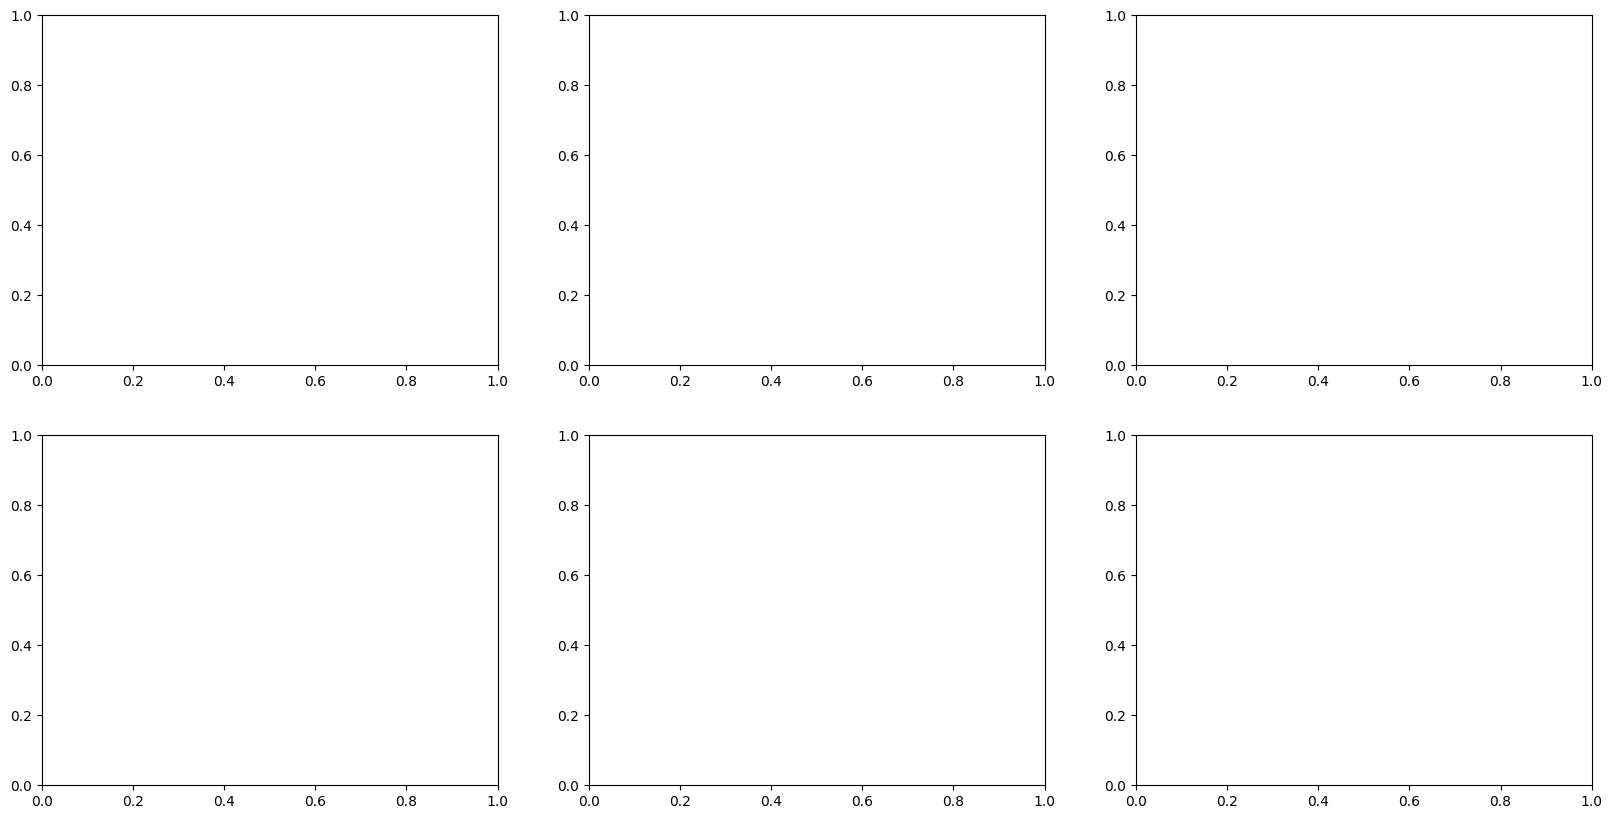

In [27]:
# =============================================================================
# FULL SALES ANALYTICS + FORECASTING PIPELINE
# Connects to SQL Server → Loads data → Analyzes → Plots → Saves Prophet Forecast
# Works in VS Code + Jupyter + .py
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from prophet import Prophet
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# 1. CONFIGURATION
# -----------------------------
CONFIG = {
    'server': '100.99.225.51',
    'database': 'TEST1',
    'username': 'SA',
    'password': 'a31536000',  # CHANGE THIS AFTER TESTING!
    'driver': '{ODBC Driver 17 for SQL Server}',
    'sql_query': '''
        SELECT *
        FROM raw_data_20251028_032812_halo
    ''',
    'product_keywords': ['product', 'item', 'name', 'customer'],
    'category_keywords': ['category', 'brand'],
    'quantity_keywords': ['quantity', 'qty', 'units', 'sold'],
    'top_n': 5,
    'plot_title_prefix': 'Sales Analytics'
}

# -----------------------------
# 2. HELPER: Safe Column Detection
# -----------------------------
def detect_column(df, keywords):
    for col in df.columns:
        if any(k.lower() in col.lower() for k in keywords):
            return col
    return None

def detect_date_column(df):
    date_keywords = ['date', 'time', 'order', 'ship']
    for col in df.columns:
        if any(k.lower() in col.lower() for k in date_keywords):
            return col
        try:
            pd.to_datetime(df[col], errors='coerce')
            if df[col].notna().sum() > len(df) * 0.5:
                return col
        except:
            pass
    return None

# -----------------------------
# 3. LOAD DATA FROM SQL SERVER
# -----------------------------
def load_data(config):
    conn_str = (
        f"DRIVER={config['driver']};"
        f"SERVER={config['server']};"
        f"DATABASE={config['database']};"
        f"UID={config['username']};"
        f"PWD={config['password']};"
        f"Encrypt=yes;"
        f"TrustServerCertificate=yes;"
        f"Connection Timeout=30;"
    )
    try:
        conn = pyodbc.connect(conn_str)
        df = pd.read_sql(config['sql_query'], conn)
        conn.close()
        print(f"Loaded {len(df)} rows from SQL Server.")
        
        if len(df) == 0:
            print("No data returned. Check your table/query.")
            return None, None

        # Auto-detect columns
        sales_col = detect_column(df, ['sales', 'revenue', 'amount', 'total'])
        product_col = detect_column(df, config['product_keywords'])
        category_col = detect_column(df, config['category_keywords'])
        quantity_col = detect_column(df, config['quantity_keywords'])
        date_col = detect_date_column(df)

        # Clean
        if sales_col:
            df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce')
            df = df.dropna(subset=[sales_col])
        if date_col:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            df = df.dropna(subset=[date_col])

        detected = {
            'sales_col': sales_col,
            'product_col': product_col,
            'category_col': category_col,
            'quantity_col': quantity_col,
            'date_col': date_col
        }
        print(f"Detected: {detected}")
        return df, detected

    except Exception as e:
        print(f"Connection/Data Error: {e}")
        return None, None

# -----------------------------
# 4. COMPUTE STATISTICS (Safe for Empty Data)
# -----------------------------
def compute_statistics(df, detected):
    sales_col = detected['sales_col']
    product_col = detected['product_col']
    category_col = detected['category_col']
    quantity_col = detected['quantity_col']

    stats = {'total_revenue': 0.0}

    if len(df) == 0 or sales_col not in df.columns:
        return {k: "No data" if isinstance(v, str) else 0 for k, v in stats.items()}

    stats['total_revenue'] = df[sales_col].sum()

    # Best item
    if product_col and len(df) > 0:
        item_sales = df.groupby(product_col)[sales_col].sum()
        if len(item_sales) > 0:
            top = item_sales.nlargest(1)
            stats['best_selling_item'] = top.index[0]
            stats['best_item_revenue'] = float(top.iloc[0])
        else:
            stats['best_selling_item'] = "N/A"
            stats['best_item_revenue'] = 0.0
    else:
        stats['best_selling_item'] = None

    # Best category
    if category_col and len(df) > 0:
        cat_sales = df.groupby(category_col)[sales_col].sum()
        if len(cat_sales) > 0:
            top = cat_sales.nlargest(1)
            stats['best_selling_brand'] = top.index[0]
            stats['best_brand_revenue'] = float(top.iloc[0])
        else:
            stats['best_selling_brand'] = "N/A"
            stats['best_brand_revenue'] = 0.0
    else:
        stats['best_selling_brand'] = None

    # Most units
    if quantity_col and product_col and len(df) > 0:
        qty = df.groupby(product_col)[quantity_col].sum()
        if len(qty) > 0:
            top = qty.nlargest(1)
            stats['most_stock_item'] = top.index[0]
            stats['most_stock_qty'] = float(top.iloc[0])
        else:
            stats['most_stock_item'] = "N/A"
            stats['most_stock_qty'] = 0
    else:
        stats['most_stock_item'] = None

    return stats

# -----------------------------
# 5. PRINT STATS
# -----------------------------
def print_statistics(stats):
    print("\n" + "="*60)
    print("SALES STATISTICS SUMMARY")
    print("="*60)
    print(f"Total Revenue: ${stats.get('total_revenue', 0):,.2f}")
    
    item = stats.get('best_selling_item')
    if item and item != "N/A":
        print(f"Best Selling Item: {item} (${stats['best_item_revenue']:,.2f})")
    else:
        print("Best Selling Item: No data")

    brand = stats.get('best_selling_brand')
    if brand and brand != "N/A":
        print(f"Best Brand/Category: {brand} (${stats['best_brand_revenue']:,.2f})")
    else:
        print("Best Brand: No data")

    stock = stats.get('most_stock_item')
    if stock and stock != "N/A":
        print(f"Most Units Sold: {stock} (Qty: {stats['most_stock_qty']:,.0f})")
    else:
        print("Most Units Sold: No data")
    print("="*60)

# -----------------------------
# 6. PLOT STATISTICS (Safe)
# -----------------------------
def plot_statistics(df, detected, stats, top_n=10):
    if len(df) == 0:
        print("No data to plot.")
        return

    sales_col = detected['sales_col']
    product_col = detected['product_col']
    category_col = detected['category_col']
    quantity_col = detected['quantity_col']
    date_col = detected['date_col']

    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    # Top/Bottom Items
    if product_col:
        sales_by_product = df.groupby(product_col)[sales_col].sum()
        top = sales_by_product.nlargest(top_n)
        bottom = sales_by_product.nsmallest(top_n)
        top.plot(kind='bar', ax=axes[0,0], color='skyblue'); axes[0,0].set_title(f'Top {top_n} Items')
        bottom.plot(kind='bar', ax=axes[1,0], color='salmon'); axes[1,0].set_title(f'Bottom {top_n} Items')

    # Categories
    if category_col:
        sales_by_cat = df.groupby(category_col)[sales_col].sum()
        top = sales_by_cat.nlargest(top_n)
        bottom = sales_by_cat.nsmallest(top_n)
        top.plot(kind='bar', ax=axes[0,1], color='lightcoral'); axes[0,1].set_title(f'Top {top_n} Categories')
        bottom.plot(kind='bar', ax=axes[1,1], color='lightgray'); axes[1,1].set_title(f'Bottom {top_n} Categories')

    # Quantity
    if quantity_col and product_col:
        qty_by_product = df.groupby(product_col)[quantity_col].sum()
        top = qty_by_product.nlargest(top_n)
        bottom = qty_by_product.nsmallest(top_n)
        top.plot(kind='bar', ax=axes[0,2], color='lightgreen'); axes[0,2].set_title(f'Top {top_n} by Units')
        bottom.plot(kind='bar', ax=axes[1,2], color='wheat'); axes[1,2].set_title(f'Bottom {top_n} by Units')

    plt.suptitle("Performance Overview", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Quarterly (if date)
    if date_col:
        df_q = df.copy()
        df_q['Quarter'] = df_q[date_col].dt.to_period('Q').astype(str)
        quarterly = df_q.groupby('Quarter')[sales_col].sum()
        if len(quarterly) > 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            quarterly.plot(kind='bar', ax=ax1, color='teal'); ax1.set_title('Revenue by Quarter')
            growth = quarterly.pct_change() * 100
            colors = ['green' if x > 0 else 'red' for x in growth.dropna()]
            growth.dropna().plot(kind='bar', ax=ax2, color=colors); ax2.set_title('QoQ Growth %')
            plt.suptitle("Quarterly Performance", fontsize=16)
            plt.tight_layout()
            plt.show()

# -----------------------------
# 7. PROPHET FORECASTING + SAVE TO DB
# -----------------------------
def run_prophet_forecast(df, detected, engine):
    if len(df) == 0 or detected['date_col'] is None or detected['sales_col'] is None:
        print("Cannot forecast: missing data/date/sales.")
        return

    date_col = detected['date_col']
    sales_col = detected['sales_col']
    product_col = detected['product_col']

    forecasts = []
    for product in df[product_col].unique() if product_col else [None]:
        pdf = df[df[product_col] == product] if product_col else df
        pdf = pdf[[date_col, sales_col]].copy()
        pdf = pdf.rename(columns={date_col: 'ds', sales_col: 'y'})
        pdf = pdf.dropna()
        if len(pdf) < 2:
            continue

        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        m.fit(pdf)
        future = m.make_future_dataframe(periods=365)
        forecast = m.predict(future)
        forecast['product'] = product
        forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'product']])

    if forecasts:
        result = pd.concat(forecasts, ignore_index=True)
        result.to_sql('forecasted_sales', engine, if_exists='replace', index=False)
        print(f"Forecast saved to 'forecasted_sales' table ({len(result)} rows).")
    else:
        print("No forecast generated.")

# -----------------------------
# 8. MAIN EXECUTION
# -----------------------------
def main(config):
    df, detected = load_data(config)
    if df is None:
        return

    stats = compute_statistics(df, detected)
    print_statistics(stats)
    plot_statistics(df, detected, stats, config['top_n'])

    # Save plots
    plt.savefig("sales_report.png", dpi=150, bbox_inches='tight')
    print("Report saved: sales_report.png")

    # Prophet + Save to DB
    engine = create_engine(
        f"mssql+pyodbc://{config['username']}:{config['password']}@{config['server']}/{config['database']}"
        f"?driver=ODBC+Driver+17+for+SQL+Server&Encrypt=yes&TrustServerCertificate=yes"
    )
    run_prophet_forecast(df, detected, engine)

# -----------------------------
# RUN
# -----------------------------
if __name__ == "__main__":
    main(CONFIG)

In [20]:
import os
CSV_PATH = r"C:\Users\Fau\Desktop\datasets\datasets\dt10.csv"

print("File exists?", os.path.exists(CSV_PATH))
print("File size:", os.path.getsize(CSV_PATH) // 1024, "KB")

File exists? True
File size: 2079 KB


In [25]:
# =============================================================================
# UPLOAD dt10.csv → SQL Server `dt10` (100% GUARANTEED)
# =============================================================================

import pandas as pd
from sqlalchemy import create_engine
import os

# -----------------------------
# CONFIG
# -----------------------------
CSV_PATH   = r"C:\Users\Fau\Desktop\datasets\datasets\dt10.csv"
DB_SERVER  = "100.99.225.51"
DB_NAME    = "TEST1"
DB_USER    = "SA"
DB_PASS    = "a31536000"
TABLE_NAME = "dt10"

# -----------------------------
# 1. VERIFY
# -----------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(CSV_PATH)
print(f"Found: {CSV_PATH} ({os.path.getsize(CSV_PATH) // 1024} KB)")

# -----------------------------
# 2. READ CSV
# -----------------------------
df = pd.read_csv(CSV_PATH, parse_dates=['Order Date', 'Ship Date'], dayfirst=False)
print(f"Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# -----------------------------
# 3. CLEAN COLUMNS
# -----------------------------
def clean_col(col):
    col = str(col).strip()
    col = col.replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '')
    col = ''.join(c for c in col if c.isalnum() or c == '_')
    col = col[:120]
    return col if col and (col[0].isalpha() or col[0] == '_') else 'col_' + col

df.columns = [clean_col(c) for c in df.columns]
print("Cleaned columns:", list(df.columns))

# -----------------------------
# 4. UPLOAD (SAFE MODE)
# -----------------------------
engine = create_engine(
    f"mssql+pyodbc://{DB_USER}:{DB_PASS}@{DB_SERVER}/{DB_NAME}"
    f"?driver=ODBC+Driver+17+for+SQL+Server"
    f"&Encrypt=yes&TrustServerCertificate=yes",
    fast_executemany=False
)

print(f"Uploading to [{DB_NAME}].dbo.[{TABLE_NAME}] ...")
df.to_sql(
    name=TABLE_NAME,
    con=engine,
    schema='dbo',
    if_exists='replace',
    index=False,
    method=None,
    chunksize=100
)

print(f"SUCCESS! {len(df):,} rows → `dt10`")
print("Run in DBeaver: SELECT COUNT(*) FROM dt10;")

Found: C:\Users\Fau\Desktop\datasets\datasets\dt10.csv (2079 KB)
Loaded: 9,800 rows × 18 columns
Cleaned columns: ['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode', 'Customer_ID', 'Customer_Name', 'Segment', 'Country', 'City', 'State', 'Postal_Code', 'Region', 'Product_ID', 'Category', 'Sub_Category', 'Product_Name', 'Sales']
Uploading to [TEST1].dbo.[dt10] ...
SUCCESS! 9,800 rows → `dt10`
Run in DBeaver: SELECT COUNT(*) FROM dt10;
